In [1]:
%matplotlib inline
import matplotlib as mpl
from matplotlib import pylab as plt
import matplotlib.dates as mdates
import seaborn as sns
import collections

import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_probability as tfp

from tensorflow_probability import distributions as tfd
from tensorflow_probability import sts

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()


For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.



In [2]:
# Data import
d = pd.read_csv("https://raw.githubusercontent.com/ozt-ca/tjo.hatenablog.samples/master/r_samples/public_lib/jp/sample_marketing.csv")
forecast_steps = 16
d.iloc[:, 1:] = scaler.fit_transform(d.iloc[:, 1:])
d_train = d[:-forecast_steps]
d_test = d[-forecast_steps:]

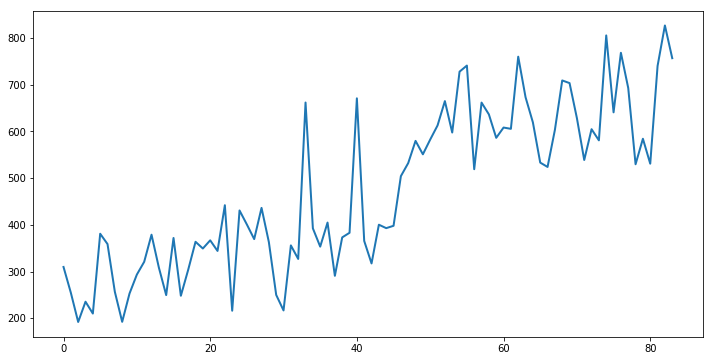

In [3]:
# Plot the original data
fig = plt.figure(figsize=(12, 6))
ax = fig.add_subplot(1, 1, 1)
ax.plot(d_train.cv, lw=2, label="training data");

In [4]:
# Define plotting function for the final result
def plot_forecast(d, validation_steps,
                  forecast_mean, forecast_scale, forecast_samples,
                  title, x_locator=None, x_formatter=None):
  """Plot a forecast distribution against the 'true' time series."""
  colors = sns.color_palette()
  c1, c2 = colors[0], colors[1]
  fig = plt.figure(figsize=(12, 6))
  ax = fig.add_subplot(1, 1, 1)

  num_steps = len(d)
  num_steps_forecast = validation_steps
  num_steps_train = num_steps - num_steps_forecast


  ax.plot(d.iloc[:, 0], lw=2, color=c1, label='ground truth')

  forecast_steps = np.arange(
      num_steps_train,
      num_steps_train+num_steps_forecast)

  ax.plot(forecast_steps, forecast_samples.T, lw=1, color=c2, alpha=0.1)

  ax.plot(forecast_steps, forecast_mean, lw=2, ls='--', color=c2,
           label='forecast')
  ax.fill_between(forecast_steps,
                   forecast_mean-2*forecast_scale,
                   forecast_mean+2*forecast_scale, color=c2, alpha=0.2)

  ymin, ymax = min(np.min(forecast_samples), np.min(d.iloc[:, 0])), max(np.max(forecast_samples), np.max(d.iloc[:, 0]))
  yrange = ymax-ymin
  ax.set_ylim([ymin - yrange*0.1, ymax + yrange*0.1])
  ax.set_title("{}".format(title))
  ax.legend()

  if x_locator is not None:
    ax.xaxis.set_major_locator(x_locator)
    ax.xaxis.set_major_formatter(x_formatter)
    fig.autofmt_xdate()

  return fig, ax

In [7]:
# Define modeling function
def build_model(observed_time_series, future_reg):
  trend = sts.LocalLinearTrend(observed_time_series=observed_time_series.iloc[:, 0])
  seasonal = tfp.sts.Seasonal(
      num_seasons=7, num_steps_per_season=1, observed_time_series=observed_time_series.iloc[:, 0])
  regression = sts.LinearRegression(design_matrix=tf.concat([observed_time_series.iloc[:, 1:], future_reg], axis=0))
  model = sts.Sum([trend, seasonal, regression], observed_time_series=observed_time_series.iloc[:, 0])
  return model

In [8]:
# Estimate a model
d_model = build_model(d_train, d_test.iloc[:, 1:])
samples, kernel_results = tfp.sts.fit_with_hmc(d_model, d_train)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.


In [9]:
# Extract MCMC samples
with tf.Session() as sess:
  sess.run(tf.global_variables_initializer())
  samples_, kernel_results_ = sess.run((samples, kernel_results))

In [10]:
# Forecast future values
d_forecast_dist = tfp.sts.forecast(d_model, d,
                                   parameter_samples=samples_,
                                   num_steps_forecast=forecast_steps)

d_forecast_mean = d_forecast_dist.mean()[..., 0]  # shape: [50]
d_forecast_scale = d_forecast_dist.stddev()[..., 0]  # shape: [50]
d_forecast_samples = d_forecast_dist.sample(10)[..., 0]  # shape: [10, 50]

Instructions for updating:
Use tf.random.categorical instead.


In [11]:
# Extract forecast values
with tf.Session() as sess:
  forecast_mean, forecast_scale, forecast_samples = sess.run((
      d_forecast_mean,
      d_forecast_scale,
      d_forecast_samples))

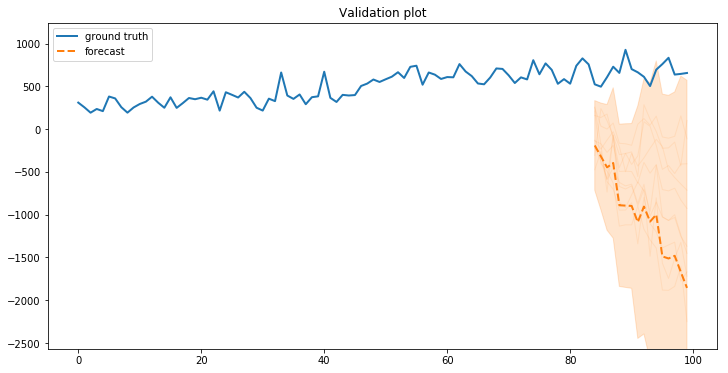

In [12]:
# Plot the final result
fig, ax = plot_forecast(d, forecast_steps,
    forecast_mean, forecast_scale, forecast_samples, "Validation plot")